### Notebook Purpose

prototype dc regularization of intermediate layers

In [1]:
import os, sys
import h5py
import numpy as np
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
import PIL

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.data_io import load_h5, get_mask, num_params
from include.decoder_conv import init_convdecoder
from include.decoder_conv import get_scale_factor, get_net_input, get_hidden_size
from include.fit import fit
from include.subsample import MaskFunc
from utils.evaluate import calc_metrics
from utils.transform import fft_2d, ifft_2d, root_sum_squares, \
                            reshape_complex_vals_to_adj_channels, \
                            reshape_adj_channels_to_complex_vals, \
                            crop_center

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(0)
else:
    dtype = torch.FloatTensor

# STATUS

### done:
- done: extracted feature maps
    - actually getting collapsed channels from original feature maps, i.e. 160 --> 30 via 1x1 conv
    - we'll be computing mse w dimn [2*nc, x_, y_]
- applied a mask to the feat_map
    - ksp_m_down, shape [x_,y_], has many zero values. feat_map doesn't have zero values
    - we compute mse(feat_map, ksp_m_down) for each layer
    - do we want to penalize zero values in ksp_m_down? i don't think so
        - we just don't have a prior at those indices. the true value is surely not zero
        - if we did penalize perfectly, we'd recreate ksp_masked. want to allow the network expressive freedom to re-create ksp_orig
- normalized ksp_m_down according to feat_map so we maintain distribution of feat_map
- performed weighted mse so we apply the same weight to each pixel
    - last layer has 2000x as many pixels as first layer

### possible implementation todo's
- try only applying feat_map_loss in last x iterations
- try weighting earlier/later layers more heavily
- currently we downsample ksp_masked according to the size of each hidden layer's feat_map
    - instead, we could upsample each feat_map and compute its loss with the original-size ksp_masked
        - this would encourage network to learn upsampling according to upsample_mode='nearest' 
- could use different downsampling methods to create ksp_m_down
    - currently using most expressive method, i.e. bicubic
    - other options
        - nearest, i.e. inverse method used by dd+ for upsampling
        - bilinear

In [2]:
class Conv_Model(nn.Module):
    def __init__(self, num_layers, num_channels, out_depth, hidden_size,
                 upsample_mode='nearest', kernel_size=3, bias=False):

        super(Conv_Model, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.upsample_mode = upsample_mode

        # define layer types
        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size, \
                         stride=1, padding=1, bias=bias)
        self.bn = nn.BatchNorm2d(num_channels, affine=True)
        self.collapse_channels = nn.Conv2d(num_channels, out_depth, 1, 1, padding=0, bias=bias)
        
        self.upsamp_list = []
        for size in hidden_size:
            self.upsamp_list.append(nn.Upsample(size=size, mode=upsample_mode))

    def forward(self, x):
        ''' run input thru net1 (convdecoder) then net2 (converts number of channels)
        provide options for skip connections (default False) and scaling factors (default 1) '''
        
        feat_maps = []
        
        for upsamp in self.upsamp_list:
            x = self.bn(F.relu(self.conv(upsamp(x))))
            feat_maps.append(self.collapse_channels(x)[0])
        
        # last layer: collapse channels, don't upsample
        x = self.collapse_channels(self.bn(F.relu(self.conv(x))))

        return x, feat_maps

In [3]:
def init_convdecoder(ksp_orig, mask, \
                     in_size=[8,4], num_layers=8, num_channels=160, kernel_size=3):
    ''' wrapper function for initializing convdecoder based on input ksp_orig

        parameters:
                ksp_orig: original, unmasked k-space measurements
                mask: mask used to downsample original k-space
        return:
                net: initialized convdecoder
                net_input: random, scaled input seed
                ksp_orig: scaled version of input '''

    out_size = ksp_orig.shape[1:] # shape of (x,y) image slice, e.g. (640, 368)
    out_depth = ksp_orig.shape[0]*2 # 2*n_c, i.e. 2*15=30 if multi-coil
    hidden_size = get_hidden_size(in_size, out_size, num_layers) # list of intermed layer sizes

    torch.manual_seed(0)
    net = Conv_Model(num_layers, num_channels, out_depth, hidden_size).type(dtype)
#     print('# parameters of ConvDecoder:',num_params(net))

    net_input = get_net_input(num_channels, in_size)

    # create scaled ksp to be compatible w network magnitude
    scale_factor = get_scale_factor(net, net_input, ksp_orig)
    ksp_orig_ = ksp_orig * scale_factor

    return net, net_input, ksp_orig_, hidden_size

In [34]:
mse = torch.nn.MSELoss()

def fit(ksp_masked, img_masked, net, net_input, mask2d, num_iter, lr=0.01, alpha_fm=0):

    net_input = net_input.type(dtype)
    best_net = copy.deepcopy(net)
    best_mse = 10000.0
    mse_wrt_ksp, mse_wrt_img = np.zeros(num_iter), np.zeros(num_iter)

    p = [x for x in net.parameters()]
    optimizer = torch.optim.Adam(p, lr=lr,weight_decay=0)
    mse = torch.nn.MSELoss()

    # convert complex [nc,x,y] --> real [2*nc,x,y] to match w net output
    ksp_masked = reshape_complex_vals_to_adj_channels(ksp_masked).cuda()
    img_masked = reshape_complex_vals_to_adj_channels(img_masked)[None,:].cuda()
    mask2d = mask2d.cuda()
    
    # if performing feat map regulariz'n
    ksp_m_down_list, feat_map_mask_list, w_pix_list = \
                        get_meta_for_feat_map_loss(hidden_size, ksp_masked)

    for i in range(num_iter):
        def closure(): # execute this for each iteration (gradient step)

            optimizer.zero_grad()

            out, feat_map_list = net(net_input) # out is in img space
            out_ksp_masked = forwardm(out, mask2d).cuda() # convert img to ksp, apply mask

            #if DC_STEP: # ... see code inlay at bottom of file
            loss_ksp = mse(out_ksp_masked, ksp_masked)
            
            if i >= 800:
                loss_feat_maps = get_loss_feat_maps(feat_map_list, ksp_m_down_list, 
                                                    feat_map_mask_list, w_pix_list)
                loss_total = loss_ksp + alpha_fm*loss_feat_maps
            else:
                loss_total = loss_ksp

            loss_total.backward(retain_graph=False)

            # store loss over each iteration
            mse_wrt_ksp[i] = loss_ksp.data.cpu().numpy()
            loss_img = mse(out, img_masked) # loss in img space
            mse_wrt_img[i] = loss_img.data.cpu().numpy()

            return loss_ksp

        loss = optimizer.step(closure)

        # at each iteration, check if loss improves by 1%. if so, a new best net
        loss_val = loss.data
        if best_mse > 1.005*loss_val:
            best_mse = loss_val
            best_net = copy.deepcopy(net)

    return best_net, mse_wrt_ksp, mse_wrt_img


def forwardm(img, mask):
    ''' convert img --> ksp (must be complex for fft), apply mask
        input, output should have dim [2*nc,x,y] '''

    img = reshape_adj_channels_to_complex_vals(img[0])
    ksp = fft_2d(img).cuda()
    ksp_masked_ = ksp * mask

    return reshape_complex_vals_to_adj_channels(ksp_masked_)

from utils.evaluate import normalize_img

def get_loss_feat_maps(feat_map_list, ksp_m_down_list, \
                       feat_map_mask_list, w_pix_list):
    ''' given feat_maps: hidden layer outputs of size [30,x_,y_], i.e. hidden_size
            ksp_m_down_list: downsampled ksp_masked according to each [x_,y_]
        compute weighted mse(feat_map_list, ksp_m_down_list) '''
    
    
    
    loss_feat = 0
    for idx, feat_map in enumerate(feat_map_list):
        
        # mask feat_map s.t. we don't penalized the masked indices in ksp_masked
        feat_map_m = feat_map * feat_map_mask_list[idx]
        
        # normalize ksp_m_down so we compute mse across similar distributions
        ksp_m_down_norm = normalize_img(feat_map_m, ksp_m_down_list[idx]).cuda()
        # overwrite masked indices which were non-zero'ed by normaliz'n
        ksp_m_down_norm = ksp_m_down_norm * feat_map_mask_list[idx]
        
#         if idx == 0:
#             print(feat_map_m[0])
#             print(ksp_m_down_norm[0])
        
        # compute mse, weighted to account for different num_pix in different layers
        loss_feat += w_pix_list[idx] * mse(feat_map_m, ksp_m_down_norm)
        
    return loss_feat

def get_meta_for_feat_map_loss(hidden_size, ksp_masked, \
                               downsamp_mode='bicubic',
                               weighting='all'):
    ''' given: 
            ksp_masked: masked version of k-space
            hidden_size: list of [x_,y_], each the size of that hidden layer
            downsamp_mode: e.g. 'nearest', 'bilinear', or 'bicubic'
            weighting: whether to apply fm_loss on 'early', 'late', or 'all' layers
        return: 
            ksp_m_down_list: downsampled ksp_masked according to each [x_,y_]
            feat_map_mask_list: binary mask for applying to feat_map s.t. we are not
                                penalizing against the zero columns in ksp_m_down
            w_pix: weights s.t. pixels from different layers are weighted equally '''
    
    if downsamp_mode == 'bicubic':
        interp = PIL.Image.BICUBIC
    elif downsamp_mode == 'bilinear':
        interp = PIL.Image.BILINEAR
    elif downsamp_mode == 'nearest':
        interp = PIL.Image.NEAREST
    
    ksp_m_down_list, feat_map_mask_list = [], []
    
    for layer_size in hidden_size:
        
        # downsample ksp_masked according to each layer size
        downsamp = torchvision.transforms.Resize(layer_size, interpolation=interp)
        ksp_m_down = downsamp(ksp_masked)
        ksp_m_down_list.append(ksp_m_down)
        
        # create 1d mask w 1 if that row contains all zeros, 0 otw
        chan = ksp_m_down[0] # get single channel [x,y] from [2*nc,x,y]
        fm_mask = torch.where(torch.sum(chan, dim=0)==0, 0, 1).type(torch.uint8)
        feat_map_mask_list.append(fm_mask)
    
    pix_per_layer = np.array([x[0]*x[1] for x in hidden_size])
    w_pix_list = np.array([pix_per_layer.sum() / x for x in pix_per_layer])
    
    # if we want to weight early or later layers
    assert(len(w_pix_list) == 7)
    if weighting == 'early':
        w_pix_list[-3:] = 0
    elif weighting == 'late':
        w_pix_list[:4] = 0
    
    return ksp_m_down_list, feat_map_mask_list, w_pix_list

### how to run this over a bunch of settings

- make a dataframe where indiv row is one config setting, indiv column is one sample
- rows, i.e. config attributes, according to one run_id
    - num_iter
        - total
        - at which we turn on fm_loss, i.e. 0.5 * total and 0.8 * total
    - alpha_fm = 10 ** exp
    - weighting: early, late, or all
    - downsampling method: nearest, bilinear, bicubic
- each entry will be one sample's scores as a tuple w (ssim, psnr)

### TODO
- figure out how to run over all combinations: either method used in fdvd or iterating over zipped list
- must set up s.t. all args pass down to necessary lower level functions
- must write single line of csv for each run_id & file_id combination
    - run_id, file_id, ssim, psnr, alpha_fm, num_iter, iter_start_fm_loss, weight_method, downsamp_method

### all combinations and method for generating random run_id

In [45]:
exp_list = [-2, -3, -4, -5, -10]
alpha_fm_list = [10**e for e in exp_list]

weighting_options = ['all', 'early', 'late']
downsamp_options = ['bicubic', 'bilinear', 'nearest']

ITER_START_FM_LOSS = [0, int(0.5*NUM_ITER), int(0.8*NUM_ITER)]
ITER_START_FM_LOSS

import random, string
''.join(random.choices(string.ascii_lowercase + string.digits, k=6))

[0, 500, 800]

In [39]:
DIM = 320
SCALE_FAC = 0.1
NUM_ITER = 1000

file_id_list = ['1000273']#, '1000325', '1000464', '1000007', '1000537', '1000818', \
#                  '1001140', '1001219', '1001338', '1001598', '1001533', '1001798']
file_id_list.sort()

exp_list = [-1]#-2, -3, -4, -5, -10] # i.e. loss = loss_ksp + 10**exp * loss_feat_map

imgs_run_list = []

for file_id in file_id_list:

    f, ksp_orig = load_h5(file_id)
    ksp_orig = torch.from_numpy(ksp_orig)

    mask = get_mask(ksp_orig)
    
    for exp in exp_list:

        net, net_input, ksp_orig_, hidden_size = init_convdecoder(ksp_orig, mask)

        ksp_masked = SCALE_FAC * ksp_orig_ * mask
        img_masked = ifft_2d(ksp_masked)

        net, mse_wrt_ksp, mse_wrt_img = fit(
            ksp_masked=ksp_masked, img_masked=img_masked,
            net=net, net_input=net_input, mask2d=mask, num_iter=NUM_ITER,\
            alpha_fm=10**exp)


        # use above two lines when we don't want to access feature maps
        img_out = net(net_input.type(dtype))
        img_out = img_out[0] if type(img_out) is tuple else img_out
    #     img_out, feat_maps = net(net_input.type(dtype))

        img_out = reshape_adj_channels_to_complex_vals(img_out[0])
        ksp_est = fft_2d(img_out)
        ksp_dc = torch.where(mask, ksp_masked, ksp_est)

        img_masked = crop_center(root_sum_squares(ifft_2d(ksp_masked)).detach(), DIM, DIM)
        img_est = crop_center(root_sum_squares(ifft_2d(ksp_est)).detach(), DIM, DIM)
        img_dc = crop_center(root_sum_squares(ifft_2d(ksp_dc)).detach(), DIM, DIM)
        img_gt = crop_center(root_sum_squares(ifft_2d(ksp_orig)), DIM, DIM)
        imgs_run_list.append([img_masked, img_est, img_dc, img_gt])

    #     np.save('{}{}_est.npy'.format(path_out, file_id), img_est)
    #     np.save('{}{}_dc.npy'.format(path_out, file_id), img_dc)
    #     np.save('{}{}_gt.npy'.format(path_out, file_id), img_gt)

In [40]:
for idx_e, exp in enumerate(exp_list):
    
    print(exp)
    
    imgs_run = imgs_run_list[idx_e]
    img_masked, img_est, img_dc, img_gt = imgs_run[0], imgs_run[1], imgs_run[2], imgs_run[3]
    
    _, _, ssim_, psnr_ = calc_metrics(np.array(img_dc), np.array(img_gt))
    
    print(np.round(ssim_, 3), np.round(psnr_, 3))

-1
0.72 28.952


In [20]:
for idx_e, exp in enumerate(exp_list):
    
    print(exp)
    
    imgs_run = imgs_run_list[idx_e]
    img_masked, img_est, img_dc, img_gt = imgs_run[0], imgs_run[1], imgs_run[2], imgs_run[3]
    
    _, _, ssim_, psnr_ = calc_metrics(np.array(img_dc), np.array(img_gt))
    
    print(np.round(ssim_, 3), np.round(psnr_, 3))

-2
0.726 29.158
-3
0.552 21.671
-4
0.716 28.648
-5
0.718 28.853
-10
0.723 29.096


In [17]:
for idx_e, exp in enumerate(exp_list):
    
    print(exp)
    
    imgs_run = imgs_run_list[idx_e]
    img_masked, img_est, img_dc, img_gt = imgs_run[0], imgs_run[1], imgs_run[2], imgs_run[3]
    
    _, _, ssim_, psnr_ = calc_metrics(np.array(img_dc), np.array(img_gt))
    
    print(np.round(ssim_, 3), np.round(psnr_, 3))

-10
0.719 28.907
-2
0.682 28.116
-3
0.639 27.314
-4
0.71 28.632
-5
0.717 28.933


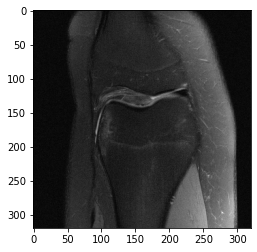

In [195]:
plt.imshow(img_gt, cmap='gray')